In [3]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

ModuleNotFoundError: No module named 'transformers'

In [1]:
import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F

In [25]:
class GPTConfig:
    """ GPT-1 like network roughly 125M params """
    n_head = 10
    n_embd = 300
    block_size = 128
    attn_pdrop = 0.1
    resid_pdrop = 0.1
    

In [26]:
config = GPTConfig()

In [112]:
class SynthesizerAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # NEW learnable weights
        self.w1 = nn.Linear(config.n_embd, config.n_embd)
        self.w2 = nn.Parameter(torch.zeros(config.n_embd // config.n_head,
            config.block_size-1))
        self.b1 = nn.Parameter(torch.zeros(config.block_size-1))
        self.b2 = nn.Parameter(torch.zeros(config.block_size-1))
        self.relu = nn.ReLU()
        # value projection
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in
        #     the input sequence
        self.register_buffer("mask", torch.tril(
            torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.block_size = config.block_size

        nn.init.uniform_(self.w2, -0.001, 0.001)

    def forward(self, x, layer_past=None):
        # TODO [part g]: Write your SynthesizerAttention below.
        #   Do not modify __init__().
        # Yi = softmax(ReLU(XAi + b1)Bi + b2)(XVi)
        # Hints:
        #   - Paste over the CausalSelfAttention above and modify it minimally.
        #   - Consider especially the parameters self.w1, self.w2 and self.b2.
        #       How do these map to the matrices in the handout?
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        XA = self.w1(x)
        XA = XA.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        print(XA.shape, self.w2.shape)
        att = self.relu(XA) @ self.w2[:, :T] + self.b2[:T]
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        print(att.shape)

        XV = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        print(XV.shape)

        y = att @ XV # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        return y

In [113]:
X = torch.ones((8, 64, 300))


In [115]:
synt = SynthesizerAttention(config)
synt.forward(X).shape

torch.Size([8, 10, 64, 30]) torch.Size([30, 127])
torch.Size([8, 10, 64, 64])
torch.Size([8, 10, 64, 30])


torch.Size([8, 64, 300])

In [24]:
class Attention(nn.Module):
    def __init__(self, head_size, num_embed, block_size, dropout):
        super().__init__()
        # block size - max length of input sequence
        self.key = nn.Linear(num_embed, head_size, bias=False)
        self.query = nn.Linear(num_embed, head_size, bias=False)
        self.value = nn.Linear(num_embed, head_size, bias=False)

        # Register in buffer to keep tensor in state_dict() but neglect grad computations
        # registring a triangular part (everything above diagonal is zeroed-out)
        # this is necessary to mask future words for decoder part
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape  # C - num_embed
        d_model_norm = C**-0.5  # for normalization or divide by head size
        k = self.key(x)  # B, T, HEAD_SIZE
        q = self.query(x)  # B, T, HEAD_SIZE
        v = self.values(x)  # B, T, HEAD_SIZE
        weights = q @ k.transpose(-2, -1) * d_model_norm  # B, T, T
        # -inf will be turned into "0" by softmax
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float("-inf"))  # B, T, T
        weights = self.dropout(weights)
        att_scores = weights @ v  # B, T, HEAD_SIZE

        return att_scores


In [25]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, num_embed, block_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([
            Attention(
                head_size=head_size,
                num_embed=num_embed,
                block_size=block_size,
                dropout=dropout
            )
            for _ in range(num_heads)
        ])
        self.proj = nn.Linear(head_size*num_heads, num_embed)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))

        return out

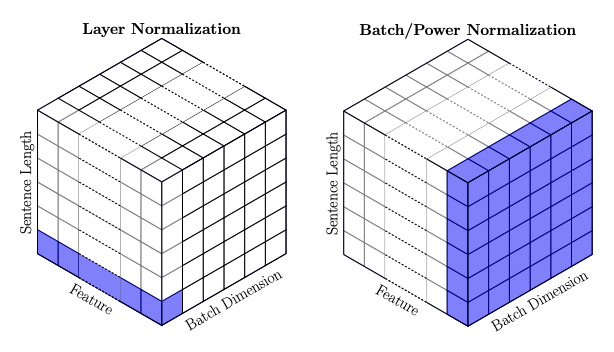

In [26]:
class FeedForward(nn.Module):
    def __init__(self, num_embed, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_embed, 4*num_embed),
            nn.ReLU(),
            nn.Linear(4*num_embed, num_embed),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [47]:
class TransformerBlock(nn.Module):
    def __init__(self, num_embed, num_heads, head_size, block_size, dropout):
        super().__init__()
        self.att = MultiHeadAttention(
            num_heads=num_heads,
            num_embed=num_embed,
            head_size=head_size,
            block_size=block_size,
            dropout=dropout
        )
        self.ffwd = FeedForward(num_embed=num_embed, dropout=dropout)
        self.ln1 = nn.LayerNorm(num_embed)
        self.ln2 = nn.LayerNorm(num_embed)

    def forward(self, x):
        x = x + self.ffwd(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

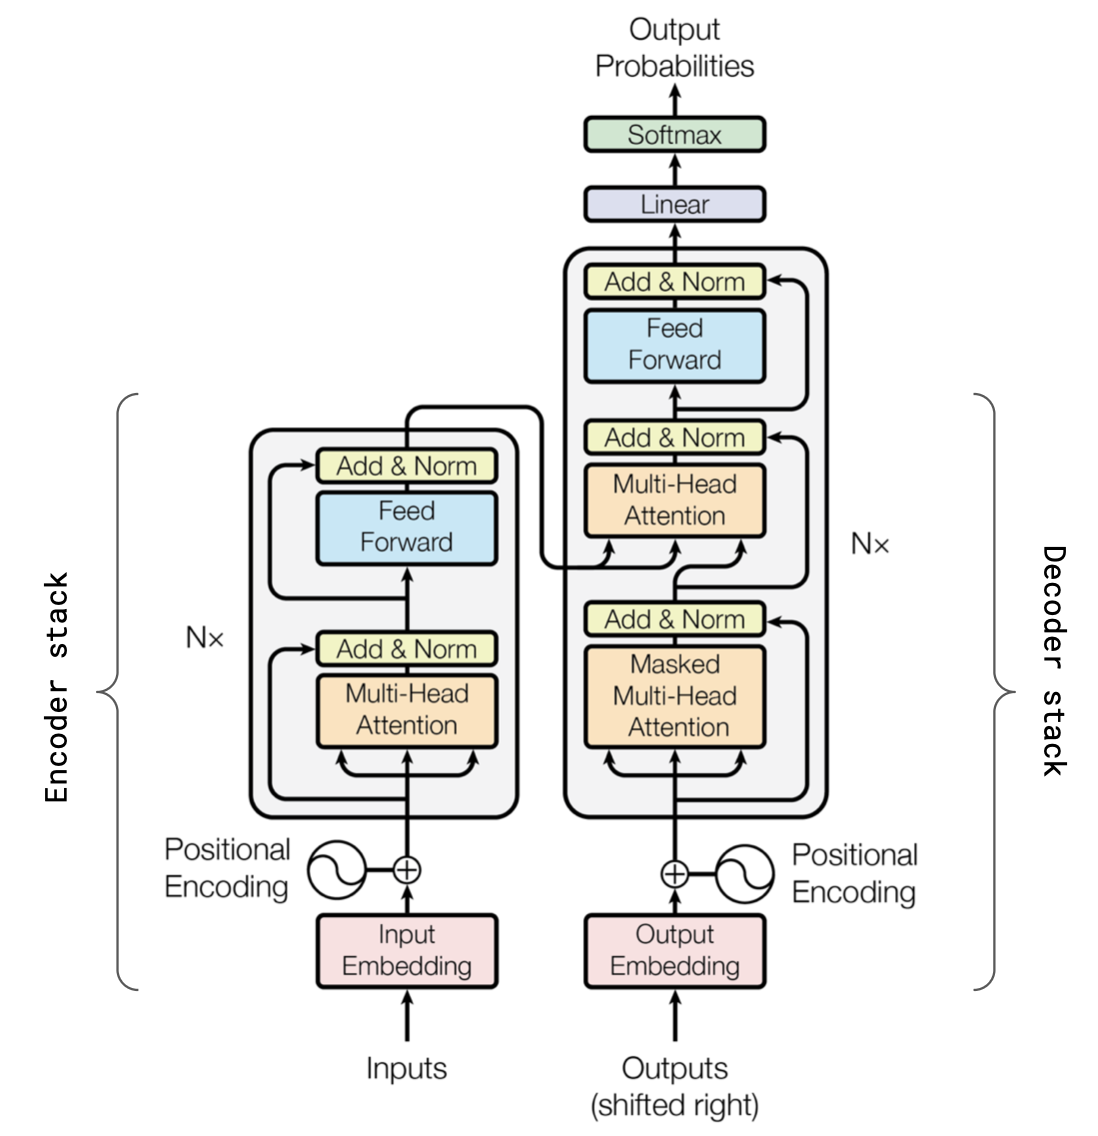

In [48]:
class Transformer(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.vocab_size = kwargs.get("vocab_size", 100)
        self.num_embed = kwargs.get("num_embed", 32)
        self.block_size = kwargs.get("block_size", 8)
        self.num_heads = kwargs.get("num_heads", 4)
        self.num_layers = kwargs.get("num_layers", 4)
        self.head_size = kwargs.get("head_size", self.num_embed // self.num_heads)
        self.dropout = kwargs.get("dropout", 0.2)
        
        self.token_emb_table = nn.Embedding(self.vocab_size, self.num_embed)
        self.position_emb_table = nn.Embedding(self.block_size, self.num_embed)

        self.blocks = nn.Sequential(
            *[TransformerBlock(
                num_embed=self.num_embed,
                num_heads=self.num_heads,
                head_size=self.head_size,
                block_size=self.block_size,
                dropout=self.dropout
            )
            for _ in range(self.num_layers)
            ]
        )

        self.ln_f = nn.LayerNorm(self.num_embed)
        self.lm_head = nn.Linear(self.num_embed, self.vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # B, T, C
        token_emb = self.token_emb_table(idx)
        # T, C
        posit_emb = self.position_emb_table(torch.arange(T, device='cuda'))

        # Add positional embeddings to token embeddings
        x = token_emb + posit_emb
        x = self.ln_f(self.blocks(x))
        logits = self.lm_head(x)

        if targets != None:
            # cross_entropy accepts inputs in a (batch_size, num_classes)
            # so we need to reformat our logits dimensions to
            # (batch_size * time, dim_vocabulary), time = block_size
            B, T, NUM_C = logits.shape
            logits = torch.reshape(logits, (B*T, NUM_C))
            targets = torch.reshape(targets, (B * T,))

            loss = torch.nn.functional.cross_entropy(logits, targets)
        else:
            loss = None
        return logits, loss

    def generate(self, idx, max_new_tokens, block_size):
        for _ in range(max_new_tokens):
            # Take last block_size tokens as context
            idx_crop = idx[:, -block_size:]
            logits, loss = self.forward(idx_crop)
            # Get logits only from the last time step
            logits = logits[:, -1, :]  # B, C
            # Get probs for words
            probs = torch.nn.functional.softmax(logits, dim=-1)  # B, C
            # sample from distribution with given probs
            idx_next = torch.multinomial(probs, num_samples=1)  # B, 1
            # append sampled idx to the current context
            idx = torch.cat((idx, idx_next), dim=1)  # B, T+1

        return idx


In [15]:
def get_batch(data: list, block_size: int, batch_size: int):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    # y is x shifted one position right - because we predict
    # word in y having all the previous words as context
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    return x, y

In [16]:
def encode(text_seq: str, tokenizer: any) -> torch.Tensor:
    """
    Function to encode input text using a pre-trained tokenizer and vectorized lookups
    """
    # tokenize the input text
    tokens = tokenizer.tokenize(text_seq)
    # convert the tokens to their corresponding ids
    token_indices = tokenizer.convert_tokens_to_ids(tokens)
    token_indices = torch.tensor(token_indices, dtype=torch.long)
    return token_indices


def decode(enc_sec: torch.Tensor, tokenizer: any) -> str:
    """
    Function to decode a sequence of token indices back to a string
    """
    # convert the indices to a list
    enc_sec = enc_sec.tolist()
    # decode the indices to a string
    text = tokenizer.decode(enc_sec)
    return text

In [17]:
data_raw = open('english.txt', encoding="utf-8").read()
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
vocab_size = tokenizer.vocab_size

# train/val split
data = encode(text_seq=data_raw, tokenizer=tokenizer)

n = int(0.9 * len(data))  # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [18]:
xb, yb = get_batch(train_data, 64, 16)

In [19]:
decode(xb[0], tokenizer)

'much am i paying you? how much am i paying you? how much am i paying you? how much are the oranges? how much are these shoes? how much are these shoes? how much do you love tom? how much do you remember? how much do you remember? how much for half a ki'

In [20]:
decode(yb[0], tokenizer)

'am i paying you? how much am i paying you? how much am i paying you? how much are the oranges? how much are these shoes? how much are these shoes? how much do you love tom? how much do you remember? how much do you remember? how much for half a kilo'

In [49]:
# hyperparameters
BATCH_SIZE = 16  # how many independent sequences will we process in parallel?
BLOCK_SIZE = 64  # what is the maximum context length for predictions?
MAX_ITER = 5000  # number of training iterations
LEARNING_RATE = 3e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_HEAD = 6
NUM_EMBED = 768
HEAD_SIZE = NUM_EMBED // NUM_HEAD
NUM_LAYER = 6
DROPOUT = 0.2
EVAL_INTER = 100

In [50]:
model = Transformer(
    vocab_size=vocab_size,
    num_embed=NUM_EMBED,
    block_size=BLOCK_SIZE,
    num_heads=NUM_HEAD,
    num_layers=NUM_LAYER,
    dropout=DROPOUT,
)

In [51]:
device = 'cuda'

In [52]:
@torch.no_grad()
def estimate_loss(
    data: list,
    model: torch.nn.Module,
    block_size: int,
    batch_size: int,
    eval_iters: int = 10,
):
    out = {}
    model.eval()
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        X, Y = get_batch(data=data, block_size=block_size, batch_size=batch_size)
        logits, loss = model.forward(X.to(device), Y.to(device))
        losses[k] = loss.item()
    out = losses.mean()
    model.train()
    return out

In [53]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [54]:
model.to(device)

Transformer(
  (token_emb_table): Embedding(30522, 768)
  (position_emb_table): Embedding(64, 768)
  (blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Attention(
            (key): Linear(in_features=768, out_features=128, bias=False)
            (query): Linear(in_features=768, out_features=128, bias=False)
            (value): Linear(in_features=768, out_features=128, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): ReLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_a

In [55]:
model.eval()
for step in range(MAX_ITER):
    optimizer.zero_grad()
    
    # every EVAL_INTER evaluate the loss on train and val sets
    if step % EVAL_INTER == 0 or step == MAX_ITER - 1:
        loss_train = estimate_loss(
            data=train_data, model=model, block_size=BLOCK_SIZE, batch_size=BATCH_SIZE
        )
        loss_val = estimate_loss(
            data=val_data, model=model, block_size=BLOCK_SIZE, batch_size=BATCH_SIZE
        )
        print("step {:10} | train loss {:6.4f} | val loss {:6.4f}".format(step, loss_train, loss_val))

    xb, yb = get_batch(train_data, block_size=BLOCK_SIZE, batch_size=BATCH_SIZE)
    logits, loss = model(xb.to(device), yb.to(device))
    loss.backward()
    optimizer.step()
    

step          0 | train loss 10.5183 | val loss 10.4949
step        100 | train loss 4.8212 | val loss 5.7463
step        200 | train loss 4.6065 | val loss 5.5032
step        300 | train loss 4.3674 | val loss 5.4348
step        400 | train loss 4.3206 | val loss 5.2956
step        500 | train loss 4.2073 | val loss 5.1373
step        600 | train loss 4.2164 | val loss 5.3027
step        700 | train loss 4.0916 | val loss 5.1534
step        800 | train loss 4.0947 | val loss 5.1651
step        900 | train loss 4.1223 | val loss 5.2193
step       1000 | train loss 4.0184 | val loss 5.1786
step       1100 | train loss 4.0025 | val loss 5.1012
step       1200 | train loss 3.9691 | val loss 5.1522
step       1300 | train loss 4.0667 | val loss 5.0723
step       1400 | train loss 3.9928 | val loss 5.0449
step       1500 | train loss 3.9360 | val loss 5.0906
step       1600 | train loss 3.9052 | val loss 4.8803
step       1700 | train loss 4.0546 | val loss 5.0650
step       1800 | train lo

In [58]:
decode(xb[0], tokenizer)

'tom wants to learn to sing in french. tom wants to open his own restaurant. tom warned me it would be noisy here. tom warned me it would be smoky here. tom was accused of doing sloppy work. tom was caught selling drugs to kids. tom was caught selling drugs to kids. tom was fed up with'

In [69]:
decode(torch.tensor(model.generate(xb[0].unsqueeze(0).to(device), block_size=BLOCK_SIZE, max_new_tokens=10))[0], tokenizer)

/tmp/ipykernel_37050/3233163344.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decode(torch.tensor(model.generate(xb[0].unsqueeze(0).to(device), block_size=BLOCK_SIZE, max_new_tokens=10))[0], tokenizer)


"tom wants to learn to sing in french. tom wants to open his own restaurant. tom warned me it would be noisy here. tom warned me it would be smoky here. tom was accused of doing sloppy work. tom was caught selling drugs to kids. tom was caught selling drugs to kids. tom was fed up with a very embarrassed. i haven's your voice"

In [91]:
model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [123]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [114]:
encoding = tokenizer.batch_encode_plus(['I love Armenia so much', 'Me too'], return_tensors='pt', padding=True, truncation=True)
encoding

{'input_ids': tensor([[ 101,  146, 1567, 9917, 1177, 1277,  102],
        [ 101, 2508, 1315,  102,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0]])}

In [122]:
tokenizer.vocab['[SEP]']

102

In [121]:
tokenizer.vocab

OrderedDict([('[PAD]', 0),
             ('[unused1]', 1),
             ('[unused2]', 2),
             ('[unused3]', 3),
             ('[unused4]', 4),
             ('[unused5]', 5),
             ('[unused6]', 6),
             ('[unused7]', 7),
             ('[unused8]', 8),
             ('[unused9]', 9),
             ('[unused10]', 10),
             ('[unused11]', 11),
             ('[unused12]', 12),
             ('[unused13]', 13),
             ('[unused14]', 14),
             ('[unused15]', 15),
             ('[unused16]', 16),
             ('[unused17]', 17),
             ('[unused18]', 18),
             ('[unused19]', 19),
             ('[unused20]', 20),
             ('[unused21]', 21),
             ('[unused22]', 22),
             ('[unused23]', 23),
             ('[unused24]', 24),
             ('[unused25]', 25),
             ('[unused26]', 26),
             ('[unused27]', 27),
             ('[unused28]', 28),
             ('[unused29]', 29),
             ('[unused30]', 30),
 

In [115]:
model_output = model(**encoding)

torch.Size([2, 7, 768])

In [ ]:
# Just last layer output of BERT
model_output.last_hidden_state.shape

In [117]:
# Representation of each sequence in [CLS] (first) token followed by linear layer and tanh
model_output.pooler_output.shape

torch.Size([2, 768])